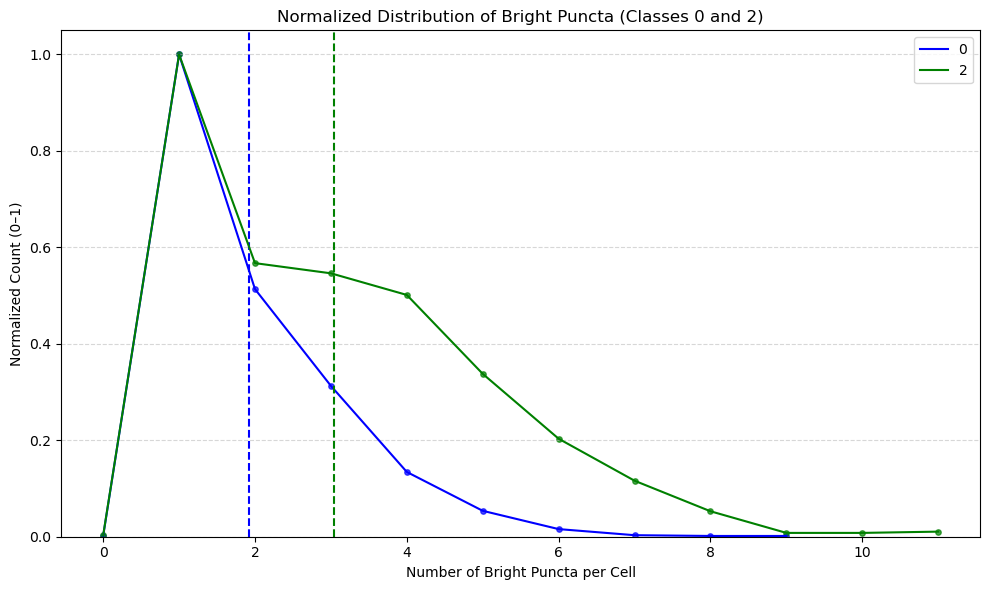

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, morphology, measure

# Root folder for DAPI images
root_dir = r"QUAC_images_protein_0/DAPI/train"

# Mapping: folder → class name
keep_map = {"13": "0", "19": "2"}

# Collect puncta counts ONLY for 13 and 19
puncta_counts = {keep_map[k]: [] for k in keep_map}

for subfolder in sorted(os.listdir(root_dir)):
    if subfolder not in keep_map:
        continue  # skip all others

    class_path = os.path.join(root_dir, subfolder)
    if not os.path.isdir(class_path):
        continue

    new_name = keep_map[subfolder]  # "0" or "2"

    for filename in os.listdir(class_path):
        if not filename.lower().endswith(".tiff"):
            continue

        img_path = os.path.join(class_path, filename)
        img = io.imread(img_path).astype(float)

        nonzero_pixels = img[img > 0]
        if len(nonzero_pixels) == 0:
            puncta_counts[new_name].append(0)
            continue

        # Otsu thresholding
        otsu_thresh = filters.threshold_otsu(nonzero_pixels)
        mask = img > otsu_thresh
        mask = morphology.remove_small_objects(mask, min_size=5)

        # Count bright puncta
        labels = measure.label(mask)    
        num_puncta = labels.max()
        puncta_counts[new_name].append(num_puncta)

# ---- PLOT STRAIGHT LINES (normalized) ----
plt.figure(figsize=(10,6))
colors = ["blue", "green"]  

for i, (cls, counts) in enumerate(puncta_counts.items()):
    counts = np.array(counts)
    if len(counts) == 0:
        continue

    # Include 0 if not present
    if np.sum(counts == 0) == 0:
        counts = np.append(counts, 0)

    # Histogram
    unique_vals, freqs = np.unique(counts, return_counts=True)
    freqs = freqs / np.sum(freqs)

    # Add (0,0) if missing
    if unique_vals[0] > 0:
        unique_vals = np.insert(unique_vals, 0, 0)
        freqs = np.insert(freqs, 0, 0)

    # Normalize to max = 1
    freqs_norm = freqs / np.max(freqs)

    # Plot
    plt.plot(unique_vals, freqs_norm, color=colors[i % len(colors)], label=cls)
    plt.scatter(unique_vals, freqs_norm, s=15,
                color=colors[i % len(colors)], alpha=0.7)

    # Mean line
    mean_val = np.mean(counts)
    plt.axvline(mean_val, color=colors[i % len(colors)], linestyle='--')

plt.xlabel("Number of Bright Puncta per Cell")
plt.ylabel("Normalized Count (0–1)")
plt.title("Normalized Distribution of Bright Puncta (Classes 0 and 2)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig("bright_puncta_distribution_filtered_0_2.pdf", dpi=300)
plt.show()


In [3]:
print("Number of cells per class:")
for cls, counts in sorted(puncta_counts.items()):
    print(f"Class {cls}: {len(counts)} cells")

Number of cells per class:
Class 0: 1289 cells
Class 2: 1270 cells
